# A Shark's Guide to Gourmet Dining

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
file_path = '/Users/haddock_ana/Ironhack/Projects/Proyect 1/Datasets/attacks.csv'
attacks = pd.read_csv(file_path, encoding="cp1252")
attacks.shape

(25723, 24)

# Data Cleaning
## First attempt
- Delete duplicated data
- Exanime Nulls (clean all nulls values)

## Second attempt
- Analyse data from the requiered study variables
  - Nulls
  - Data formats

### First cleaning

In [4]:
attacks = attacks [["Date", "Year", "Type", "Country", "Area", 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source']] # Frist subset that filters the columns I know I wont need
attacks.rename(columns = {'Sex ':'Sex', 'Species ':'Species'}, inplace=True) # Rename tha columns that have a space at the beginning

- Duplicated Values

In [5]:
attacks.duplicated().sum()

19421

In [6]:
attacks.drop_duplicates(inplace=True)

- Null values

In [7]:
attacks.isna().sum()

Date                         1
Year                         3
Type                         5
Country                     51
Area                       456
Location                   541
Activity                   545
Name                       211
Sex                        566
Age                       2831
Injury                      29
Fatal (Y/N)                540
Time                      3354
Species                   2839
Investigator or Source      18
dtype: int64

- There are variables that can be deducted or field by complementary columns.
- My approach here is to remove those cases with relevant variables (that are not posible to replace):
  - Date
  - Country

In [8]:
attacks [attacks['Date'].isnull()]
attacks.dropna(subset=['Date'], inplace=True)

The following step is to remove those cases that have these two variables null, as I think there are not useful without these key inputs of information to my analysis
- Country
- Activity

In [9]:
missing_value = attacks[(attacks['Country'].isnull()) & (attacks['Activity'].isnull())]
missing_value_indices = attacks[(attacks['Country'].isnull()) & (attacks['Activity'].isnull())].index
attacks.drop(index=missing_value_indices, inplace=True)
attacks.shape

(6294, 15)

In [10]:
attacks_v1 = attacks.copy()# Versión del df con los main nulls quitados

### Second cleaning

In this step I will prepare my final subset, by cleaning and transforming the needed variables.


In [11]:
attacks.drop(columns=['Date','Type', 'Area', 'Location', 'Name', 'Injury', 'Species','Investigator or Source'], inplace=True)

- The most important variable for my analysis focus is "Fatal (Y/N)", therefore I will start by transforming this variable.

In [12]:
attacks['Fatal (Y/N)'].str.strip()
attacks = attacks[attacks['Fatal (Y/N)'].isin(['Y', 'N'])] # I am keeping those rows that have a valid value. Either Yes or No

- Next one is the variable "Activity"

In [13]:
attacks['Activity'].replace('nan', np.nan, inplace=True) # I have detected the NaN values are in a str format, that is why I am changing the format.

In [14]:
activity_counts = attacks['Activity'].value_counts() # Analyse the different values we have for Activity
mask_activity = activity_counts[activity_counts > 10].index.tolist() # We create a variable with the Activities that are repeated more than 10 times

In [15]:
filtered_words = []
values = mask_activity # We create a set with the most repeated Activities
attacks['Activity'] = attacks['Activity'].astype(str) # ensure they have a str format

for activity in attacks['Activity']:
    words = activity.lower().split(" ")  # Convert activity to lowercase and split by ' ' to iterate over the different words
    found = False  # Create a boolean that will become true if we find a word of the set
    
    for word in words:
        if word.strip() in [val.lower() for val in values]:  # Convert values to lowercase for comparison
            filtered_words.append(word.strip())  # Append the matching word
            found = True
            break  # Exit the loop once a match is found
    
    if not found:
        filtered_words.append('others')  # Append 'others' if no match is found in any word

print(filtered_words)

['others', 'standing', 'surfing', 'surfing', 'diving', 'surfing', 'swimming', 'fishing', 'walking', 'standing', 'others', 'others', 'swimming', 'fishing', 'others', 'surfing', 'surfing', 'swimming', 'diving', 'surfing', 'surfing', 'surfing', 'surfing', 'fishing', 'others', 'others', 'swimming', 'surfing', 'surfing', 'surfing', 'fishing', 'windsurfing', 'swimming', 'surfing', 'others', 'wading', 'swimming', 'surfing', 'diving', 'swimming', 'fishing', 'walking', 'swimming', 'others', 'snorkeling', 'spearfishing', 'others', 'spearfishing', 'diving', 'diving', 'surfing', 'surfing', 'surfing', 'surfing', 'fishing', 'snorkeling', 'diving', 'diving', 'others', 'spearfishing', 'surfing', 'surfing', 'surfing', 'bathing', 'snorkeling', 'surfing', 'others', 'swimming', 'surfing', 'swimming', 'kayaking', 'kayaking', 'swimming', 'surfing', 'snorkeling', 'surfing', 'surfing', 'surfing', 'surfing', 'surfing', 'surfing', 'fishing', 'fishing', 'surfing', 'swimming', 'surfing', 'spearfishing', 'others',

In [16]:
attacks['filtered_activities']= filtered_words # Create a new column with the filtered activities

In [17]:
# I do a mapping that groups similar activities into the most common ones
attacks["filtered_activities"] = attacks["filtered_activities"].replace({
    "surf": "surfing",
    "spearfishing": "fishing",
    "surf-skiing": "surfing",
    "wading": "bathing",
    "floating": "bathing",
    "walking": "bathing",
    "windsurfing": "surfing",
    "surf-skiing": "surfing",
    "freediving": "diving",
    "freediving": "diving",
    "snorkeling": "diving",
    "snorkeling": "diving",
    "standing": "surfing",
    "boarding": "surfing",
    "rowing": "kayaking",
    "paddling": "kayaking",
    "canoeing":"kayaking"

})

In [18]:
attacks['filtered_activities'].value_counts() # See the value counts

filtered_activities
others      1525
surfing     1190
fishing      984
swimming     974
diving       529
bathing      395
kayaking      77
Name: count, dtype: int64

In [19]:
attacks.drop(columns=['Activity'], inplace=True) # We drop the old Activity column and replace it with the filtered one
attacks.rename(columns={'filtered_activities': 'Activity'}, inplace=True)

- To get a more compound insight from the activity column I will divide the data to Sports activity and Recreation activity

In [20]:
attacks['Activity_type'] = 'Unknown'

# List of sports activities
sports_activities = ['kayaking', 'surfing', 'diving', 'fishing']

# Loop through each row and check if 'Activity' is in sports_activities
for index, row in attacks.iterrows():
    if row['Activity'] in sports_activities:
        attacks.at[index, 'Activity_type'] = 'sports activity'
    else:
        attacks.at[index, 'Activity_type'] = 'recreation activity' # If the word is not in sports then we assume is a recreatin activity such as swimming or bathing

- Clean "Sex" variable

In [21]:
attacks['Sex'] = attacks['Sex'].astype(str).str.strip()
attacks = attacks [(attacks['Sex'] == 'M') | (attacks['Sex'] == 'F')]

- Clean "Age" variable. This variable has a lot of not homogenic data, that is why the cleaning and transformation needs to be a bit more concious.
  Different data types:
   - "Teen"
   - 40 - 50

In [22]:
attacks["Age"] = attacks["Age"].replace({
    "Teen": "18",
    "Teens": "18",
    "adult": "25",
    "(adult)": "25",
    "6½": "21",
    "30s": "30",
    "60s": "60",
    "60's": "60",
    "20s": "20",
    "18 months": "1",
    "young": "12",
    "mid-20s":"25",
    "middle-age": "40",
    "young" : "12",
    '9 months': "1",
    "2 to 3 months": "1" }) # I do a mapping for those values that are using a string to show a Age frame

In [23]:
# There are values that comprenhend between a range of Age, 40 - 50. For these cases I'm creating a function to take the first two number using Regex
def extract_first_number(text):
    text = str(text)
    match = re.match(r'\d+', text)
    if match:
        return int(match.group())
    else:
        return None

In [24]:
attacks['Age'] = attacks['Age'].apply(lambda x: extract_first_number(x)) # I apply the function to the column and set the values to Int
attacks['Age'] = attacks['Age'].astype('Int64')

In [25]:
attacks = attacks [attacks ['Age'].notna()] # I filtter the df to just those values with a valid age

In [26]:
# I now want to create a column that will group the Ages into generation groups
attacks['Age_Group'] = 'Unknown' # Create the new column 'Age_Group' with default value 'Unknown'

# I define the conditions and assign age groups accordingly
attacks.loc[(attacks['Age'] >= 0) & (attacks['Age'] <= 12), 'Age_Group'] = 'young'
attacks.loc[(attacks['Age'] > 12) & (attacks['Age'] <= 18), 'Age_Group'] = 'teenager'
attacks.loc[(attacks['Age'] > 18) & (attacks['Age'] <= 30), 'Age_Group'] = 'young adult'
attacks.loc[(attacks['Age'] > 30) & (attacks['Age'] <= 60), 'Age_Group'] = 'adult'
attacks.loc[(attacks['Age'] > 60), 'Age_Group'] = 'elderly'

- I follow a simir process to get ready the "Time" variable

In [27]:
def clean_time(time_str): # I create a function to get the 5 characters once the first number is found
    
    if type(time_str) == str:
        for i, char in enumerate(time_str): # Iterate over the characters in the string
        # If the character is a number
            if char.isdigit():
            # I extract the time and get only the first two digits
                 return time_str[i:i+3]
    # If no time found, return None
    pass

attacks['Time'] = attacks['Time'].apply(clean_time) # I then apply the function to clean the 'Time' column

In [28]:
# I have seen that it is easier to sort the column if I put the values as numbers.
attacks['Time'] = attacks['Time'].str.extract(r'(\d+)') # I first remove the "h" from hour

In [29]:
# Now I want to clean the column from values that are not valid times
def clean_time (text):
    text = str(text)
    match = re.match(r'^\d{2}$', text) # I look to match the value with the 2 digits of the Time 
    if match:
        return int(match.group()) # If this happens we turn the str to int
    else:
        return None

attacks['Time'] = attacks['Time'].apply(clean_time)

In [30]:
attacks = attacks.dropna(subset=['Time']) #I now drop the nan values
attacks['Time'] = attacks['Time'].astype(int)

- I create a new column that categorizes the day hours into day times

In [31]:
attacks['Day_time'] = 'Unknown'

# List of day times
Morning = [6, 7, 8, 9, 10, 11, 12]
Afternoon =  [13, 14, 15, 16, 17, 18]
Evening = [18, 19, 20, 21]

for index, row in attacks.iterrows():
    if row['Time'] in Morning:
        attacks.at[index, 'Day_time'] = 'Morning'
    elif row['Time'] in Afternoon:
        attacks.at[index, 'Day_time'] = 'Afternoon'
    elif row['Time'] in Evening:
        attacks.at[index, 'Day_time'] = 'Evening'
    else:
        attacks.at[index, 'Day_time'] = 'Night'

- Change "Year" value to int64

In [32]:
attacks['Year'] = attacks['Year'].astype('Int64')
attacks_year = attacks [attacks ['Year'].notna()]

In [33]:
attacks.head()

,Year,Country,Sex,Age,Fatal (Y/N),Time,Activity,Activity_type,Age_Group,Day_time
0,2018,USA,F,57,N,18,others,recreation activity,adult,Afternoon
1,2018,USA,F,11,N,14,surfing,sports activity,young,Afternoon
2,2018,USA,M,48,N,7,surfing,sports activity,adult,Morning
8,2018,USA,M,15,N,17,bathing,recreation activity,teenager,Afternoon
9,2018,USA,M,12,N,14,surfing,sports activity,young,Afternoon


In [34]:
attacks.isna().sum()

Year             0
Country          0
Sex              0
Age              0
Fatal (Y/N)      0
Time             0
Activity         0
Activity_type    0
Age_Group        0
Day_time         0
dtype: int64

# Data Analysis

In [35]:
selected_period = attacks[attacks['Year'] >= 1995]
attacks_year = selected_period['Year'].value_counts().reset_index()
attacks_year.columns = ['Year', 'Number of Attacks']
attacks_year = attacks_year.sort_values(by='Year')

In [36]:
custom_palette = px.colors.qualitative.Safe
fig = px.bar(attacks_year, x='Year', y='Number of Attacks', title='Number of Shark Attacks per Year since 1995',
             labels={'Year': 'Year', 'Number of Attacks': 'Number of Attacks'}, color_discrete_sequence=custom_palette)
fig.show()

## `Hypothesy 1`

**Surfers are the most vulnerable to attacks:** Sharks find it easier to prey on surfers due to their active movements and proximity to the ocean's surface, making them more accessible targets.

In [37]:
# Filter data for the last 5 years
last_attacks = attacks[attacks['Year'] >= 2010]

# Group attacks by activity and count the occurrences
activity_counts = last_attacks['Activity'].value_counts().reset_index()
activity_counts.columns = ['Activity', 'Number of Attacks']
activity_counts_sorted = activity_counts.sort_values(by='Number of Attacks', ascending=False)

# Create the bar chart
fig = px.bar(activity_counts, y='Activity', x='Number of Attacks', 
             title='Distribution of Shark Attacks by Activity (2010-2018)',
             labels={'Activity': 'Activity', 'Number of Attacks': 'Number of Attacks'},
             template='plotly', # You can change the template if needed
             color_discrete_sequence=px.colors.qualitative.Safe) # Set color palette

fig.update_layout(xaxis_tickangle=-45)

fig.show()

## `Hypothesy 2`

**Swimmers present a tougher challenge than surfers:** While reaching people swimming may require sharks to venture closer to the coast, once within range, they provide a more substantial meal compared to surfers, who may only offer an apetizer.

In [38]:
# Group attacks by Activity_type and count the occurrences
activity_type_counts = attacks['Activity_type'].value_counts().reset_index()
activity_type_counts.columns = ['Activity_type', 'Number of Attacks']

total_attacks = activity_type_counts['Number of Attacks'].sum() # Calculate the total number of attacks

# Calculate the proportion of attacks for each activity type
activity_type_counts['Proportion'] = activity_type_counts['Number of Attacks'] / total_attacks

# Create the bar chart
fig = px.bar(activity_type_counts, x='Activity_type', y='Proportion', 
             title='Proportion of Shark Attacks by Activity Type',
             labels={'Activity_type': 'Activity Type', 'Proportion': 'Proportion of Attacks'},
             template='plotly', # You can change the template if needed
             color_discrete_sequence=px.colors.qualitative.Safe) # Set color palette

fig.show()

In [39]:
activity_type_fatal_counts = attacks.groupby(['Activity_type', 'Fatal (Y/N)']).size().reset_index(name='Counts')

# Pivot the DataFrame to have Fatal (Y/N) as columns
activity_type_fatal_pivot = activity_type_fatal_counts.pivot_table(index='Activity_type', columns='Fatal (Y/N)', values='Counts', aggfunc='sum', fill_value=0).reset_index()

# Calculate the total number of attacks for each activity type
activity_type_fatal_pivot['Total'] = activity_type_fatal_pivot['N'] + activity_type_fatal_pivot['Y']
activity_type_fatal_pivot

Fatal (Y/N),Activity_type,N,Y,Total
0,recreation activity,609,203,812
1,sports activity,944,118,1062


In [40]:
# Calculate the proportion of fatal and non-fatal attacks for each activity type
activity_type_fatal_pivot['No'] = activity_type_fatal_pivot['N'] / activity_type_fatal_pivot['Total']
activity_type_fatal_pivot['Yes'] = activity_type_fatal_pivot['Y'] / activity_type_fatal_pivot['Total']

fig = px.bar(activity_type_fatal_pivot, x='Activity_type', y=['No', 'Yes'],
             title='Proportion of Shark Attacks Resulting in Fatalities by Activity Type',
             labels={'Activity_type': 'Activity Type', 'value': 'Proportion of Attacks', 'variable': 'Death'},
             color_discrete_map={'No': 'lightblue', 'Yes': 'darkblue'}, 
             barmode='group',
             opacity=0.8) # I adjust the opacity of the bars

fig.show()

## `Hypothesy 3`

**Breakfast time may be prime dining hours:** With more people engaging in sports activities during the morning, sharks may have a higher chance of encountering potential prey, leading to increased feeding opportunities.

In [41]:
# Grouping by 'Time' and counting the frequency of cases
time_frequency = attacks.groupby('Time').size().reset_index(name='Frequency')

time_frequency = time_frequency.sort_values(by='Time') # Sorting by time

# Create a line plot
fig_line = px.line(time_frequency, x='Time', y='Frequency', title='Frequency of Cases by Time')

# Create a heatmap
fig_heatmap = px.imshow([time_frequency['Frequency']], 
                        labels=dict(x="Time of Day", y=""),
                        x=time_frequency['Time'], y=[''],
                        color_continuous_scale='blues',
                        aspect='auto',
                        title='Heatmap of Shark Attacks by Time of Day')
fig_heatmap.update_xaxes(tickvals=[5, 10, 15, 20], 
                         ticktext=['Night', 'Morning', 'Afternoon', 'Evening'])


fig_line.show()
fig_heatmap.show()

In [42]:
sex_fatal_counts = attacks.groupby(['Sex', 'Fatal (Y/N)']).size().reset_index(name='Counts')
sex_fatal_pivot = sex_fatal_counts.pivot_table(index='Sex', columns='Fatal (Y/N)', values='Counts', aggfunc='sum', fill_value=0).reset_index() # Pivot the DataFrame to have Fatal (Y/N) as columns

sex_fatal_pivot['Total'] = sex_fatal_pivot['N'] + sex_fatal_pivot['Y'] 
# Calculate the total number of attacks for each activity type
sex_fatal_pivot

Fatal (Y/N),Sex,N,Y,Total
0,F,238,37,275
1,M,1315,284,1599


In [43]:
attacks_activities = attacks['Activity'].value_counts().reset_index()
activity_counts.columns = ['Activity', 'Total Count']
activity_counts

,Activity,Total Count
0,surfing,209
1,others,83
2,swimming,74
3,diving,50
4,fishing,43
5,bathing,33
6,kayaking,8


## `Hypothesy 4`

**Advanced age increases vulnerability:** Older individuals may be more susceptible to shark attacks due to potential mobility limitations and decreased ability to evade or defend against predators.

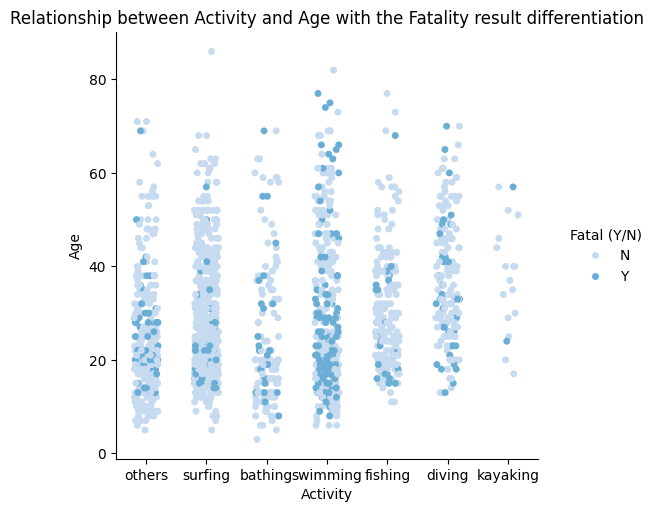

In [44]:
#sns.set_palette("Blues")
#custom_palette = ["lightblue", "darkblue"]

custom_palette = sns.color_palette("Blues", n_colors=3)
custom_palette = sns.color_palette([(r, g, b, 0.9) for (r, g, b) in custom_palette]) 

sns.set_palette(custom_palette)
sns.catplot(data=attacks, x="Activity", y='Age', hue='Fatal (Y/N)', jitter=0.2)
plt.title('Relationship between Activity and Age with the Fatality result differentiation')


plt.show()

In [45]:
# Define custom color palette with blue colors
# custom_palette = px.colors.qualitative.Blues
custom_palette = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fbff']


fig = px.box(attacks, x="Activity", y="Age", color="Fatal (Y/N)", points="all", 
             width=1500, height=600, color_discrete_sequence=custom_palette)
fig.update_layout(title_text="Box Plot of Age by Activity with Fatal (Y/N)")
fig.show()

## Other Graphs

In [46]:
selected_columns = ['Age', 'Time', 'Activity_type', 'Fatal (Y/N)'] # i select the specific columns for which you want to calculate the correlation
corr_table = attacks[selected_columns]


corr_table = pd.get_dummies(corr_table, columns=['Activity_type', 'Fatal (Y/N)'], drop_first=True)

corr_matrix = corr_table.corr() # Calculate the correlation matrix
corr_matrix

,Age,Time,Activity_type_sports activity,Fatal (Y/N)_Y
Age,1.000000,-0.162040,0.103771,-0.009078
Time,-0.162040,1.000000,-0.087559,-0.019709
Activity_type_sports activity,0.103771,-0.087559,1.000000,-0.182671
Fatal (Y/N)_Y,-0.009078,-0.019709,-0.182671,1.000000


In [47]:
columnas_categoricas = ['Activity', 'Age_Group', 'Day_time', 'Sex', 'Fatal (Y/N)']
attacks_codificado = pd.DataFrame() # DataFrame para almacenar la codificación de frecuencia


for columna in columnas_categoricas:
    frecuencias = attacks[columna].value_counts().to_dict()
    attacks_codificado[f'{columna}_freq_code'] = attacks[columna].map(frecuencias)

attacks_codificado_completo = pd.concat([attacks, attacks_codificado], axis=1)
attacks_codificado


,Activity_freq_code,Age_Group_freq_code,Day_time_freq_code,Sex_freq_code,Fatal (Y/N)_freq_code
0,308,580,1027,275,1553
1,687,122,1027,275,1553
2,687,580,767,1599,1553
8,143,430,1027,1599,1553
9,687,122,1027,1599,1553
...,...,...,...,...,...
5922,687,580,767,1599,321
5934,361,430,767,1599,1553
5963,361,687,767,1599,1553
5991,143,687,1027,1599,321


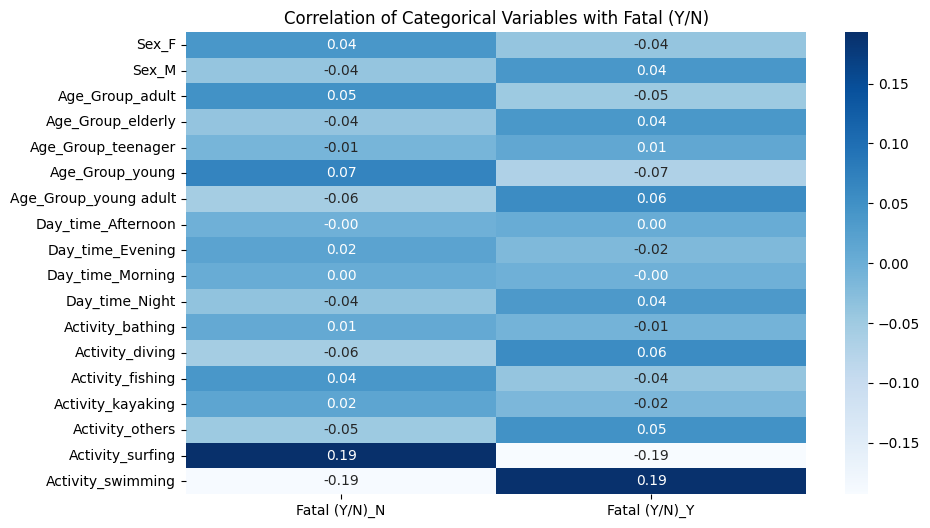

In [48]:
categorical_columns = ['Sex', 'Age_Group', 'Day_time', 'Activity', 'Fatal (Y/N)']
attacks_frequency = pd.get_dummies(attacks[categorical_columns]) # i calculate the frequency of each category for each value of 'Fatal (Y/N)'

correlation_with_fatal = attacks_frequency.corr()[['Fatal (Y/N)_N', 'Fatal (Y/N)_Y']] # Calculate the correlation with 'Fatal (Y/N)'
correlation_with_fatal = correlation_with_fatal.loc[:, correlation_with_fatal.columns.str.startswith('Fatal')]
correlation_with_fatal = correlation_with_fatal.drop(['Fatal (Y/N)_N', 'Fatal (Y/N)_Y']) # Drop the correlation of 'Fatal (Y/N)' with itself

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_with_fatal, annot=True, cmap='Blues', fmt='.2f')  # Change the colormap and formatting
plt.title('Correlation of Categorical Variables with Fatal (Y/N)')
plt.show()

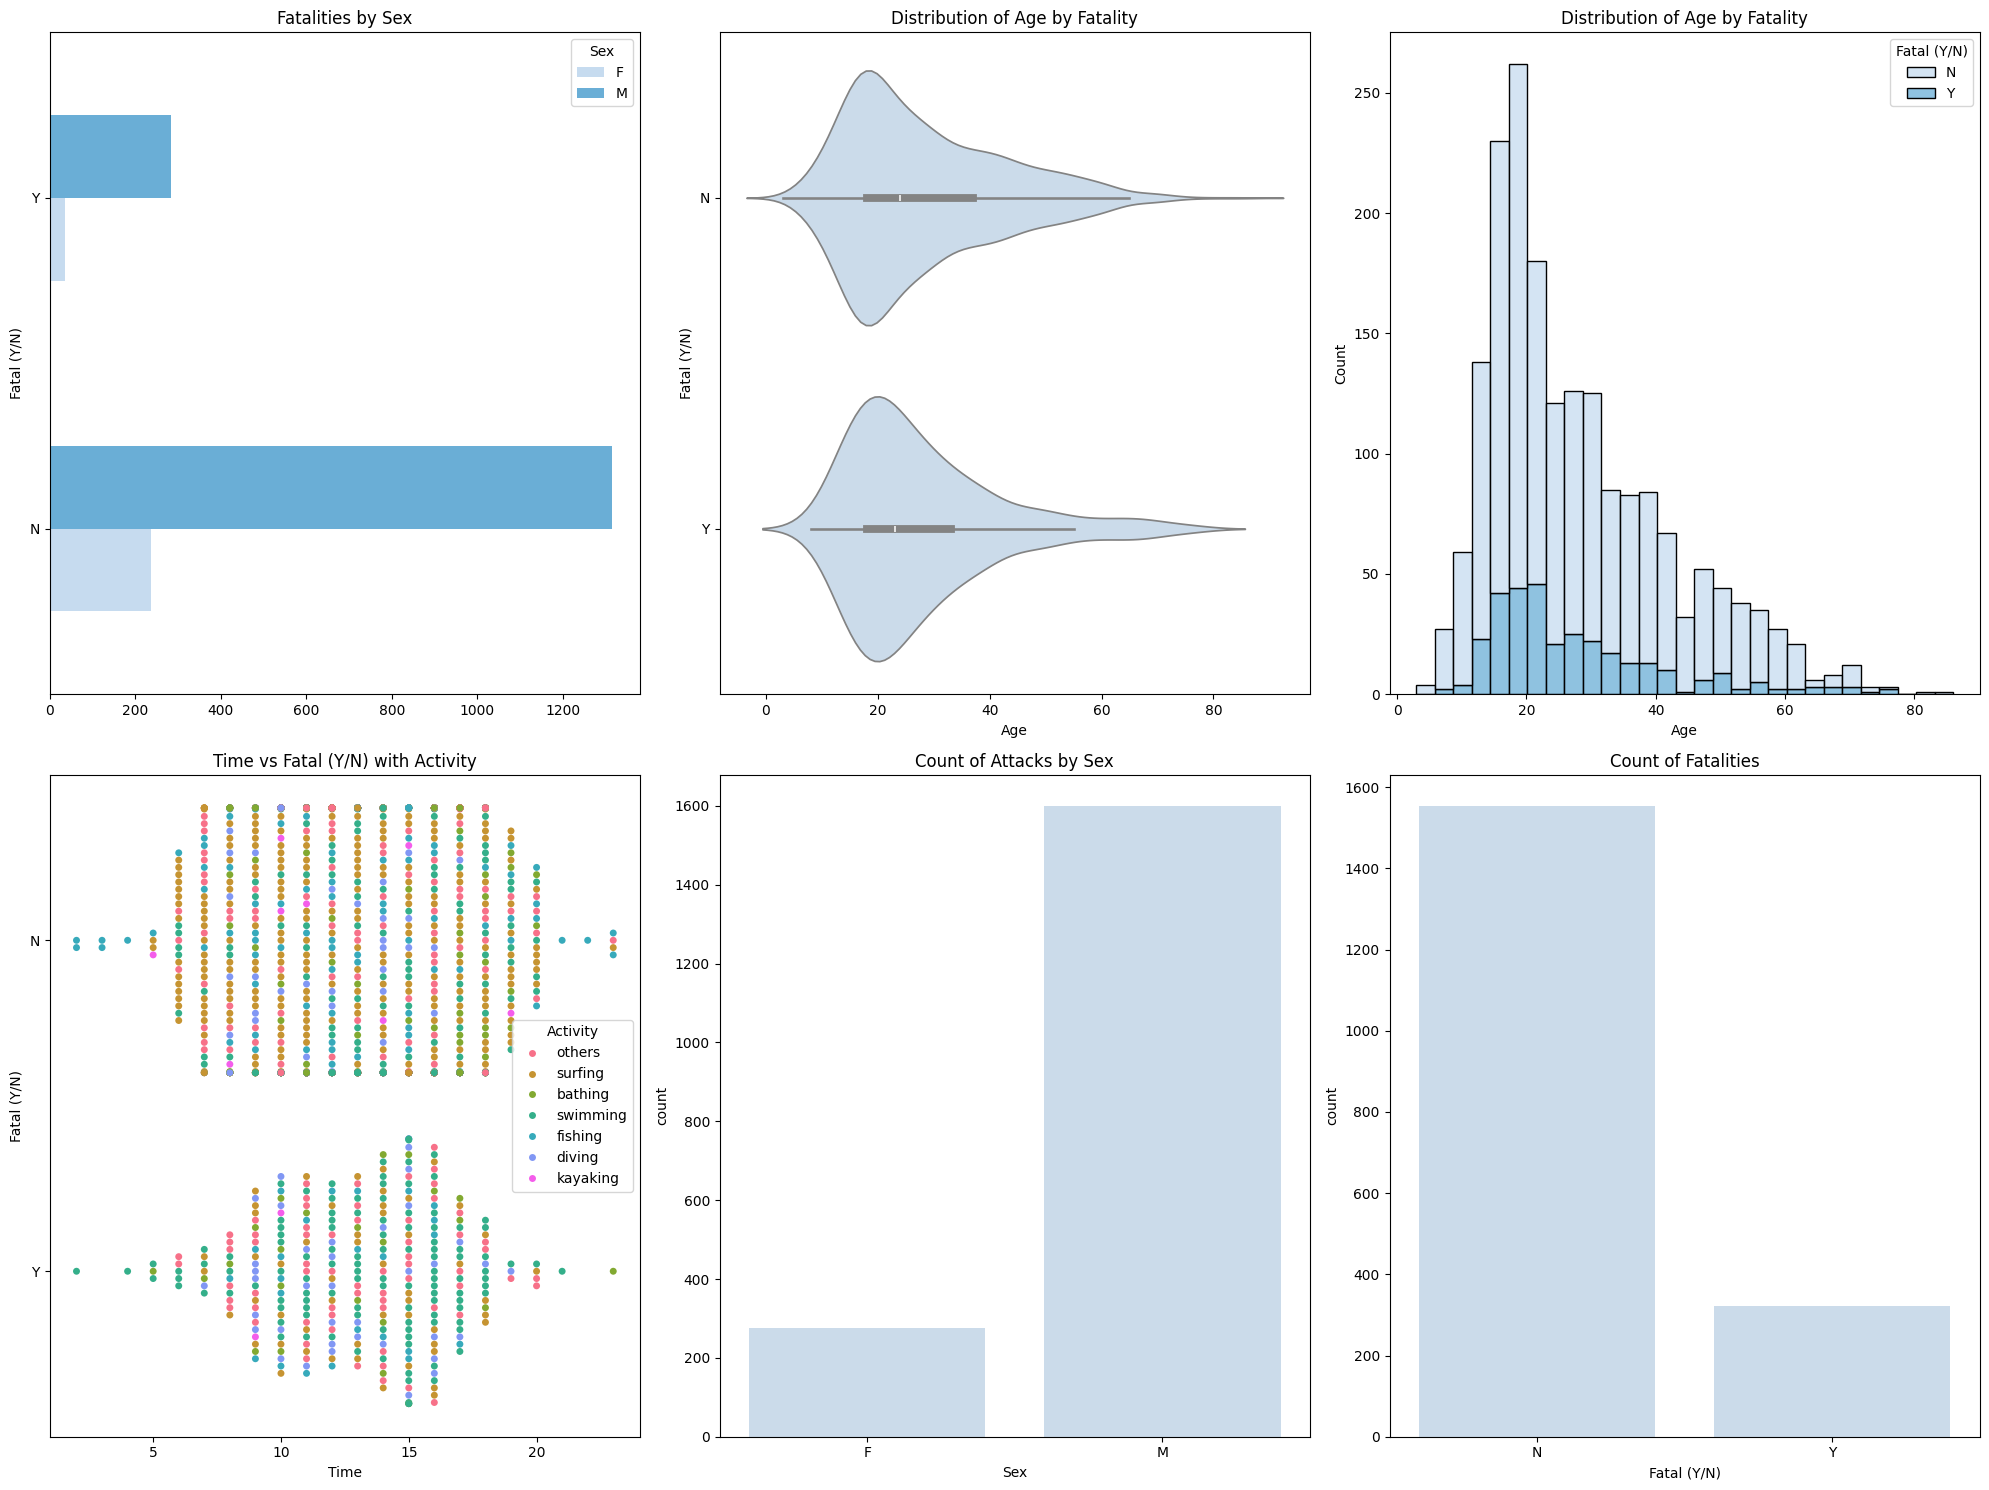

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15)) # Create subplots

fatal_sex_counts = attacks.groupby(["Fatal (Y/N)", "Sex"])["Sex"].count().unstack() # Grouping by "Fatal (Y/N)" and "Sex", and counting occurrences
fatal_sex_counts.plot(kind="barh", ax=axs[0, 0])
axs[0, 0].set_title('Fatalities by Sex')

# Violin plot for distribution of age by fatality
sns.violinplot(x=attacks["Age"], y=attacks["Fatal (Y/N)"], ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Age by Fatality')

# Stack histogram for distribution of age by fatality
sns.histplot(data=attacks, x="Age", hue="Fatal (Y/N)", multiple="stack", ax=axs[0, 2])
axs[0, 2].set_title('Distribution of Age by Fatality')

# Swarm plot for body mass by time and fatality
sns.swarmplot(data=attacks, x="Time", y="Fatal (Y/N)", hue="Activity", ax=axs[1, 0])
axs[1, 0].set_title('Time vs Fatal (Y/N) with Activity')

# Count plot for sex
sns.countplot(x=attacks["Sex"], ax=axs[1, 1])
axs[1, 1].set_title('Count of Attacks by Sex')

# Count plot for fatality
sns.countplot(x=attacks["Fatal (Y/N)"], ax=axs[1, 2])
axs[1, 2].set_title('Count of Fatalities')

plt.tight_layout()
plt.show()